In [22]:
## General Imports

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
poly,
ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

## Lab Specific Imports
from pygam import (s as s_gam,
l as l_gam,
f as f_gam,
LinearGAM,
LogisticGAM)
from ISLP.transforms import (BSpline,
NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
degrees_of_freedom,
plot as plot_gam,
anova as anova_gam)

## sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
## load wage data
wage = load_data('Wage')

# isolate variables
y = wage['wage']
age = wage['age']

display(wage)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


a. Perform polynomial regression to predict wage using age. Use
cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to
the results of hypothesis testing using ANOVA? Make a plot of
the resulting polynomial ft to the data.

In [3]:
## Create the following using a sklearn Pipeline
## I'm not performing a train test split, just practicing the syntax in a machine learning setting
## PolynomialFeatures in sklearn uses raw polynomials, as demonstrated by the coeffients 

# Define the pipeline
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=4)),  # You can change the degree if needed
    ('linear_regression', LinearRegression())
])

pipeline.fit(age.to_numpy().reshape(-1,1), y)

print(pipeline['linear_regression'].coef_)

[ 0.00000000e+00  2.12455205e+01 -5.63859312e-01  6.81068771e-03
 -3.20383037e-05]


[1793.0552320422387, 2032.8227015881428, 1504.9483599476985, 1468.0684677312995, 1665.6199066035645, 1221.4036790988075, 1364.0539169834963, 1839.3315736866284, 1719.7239552845508, 1561.671998745227]


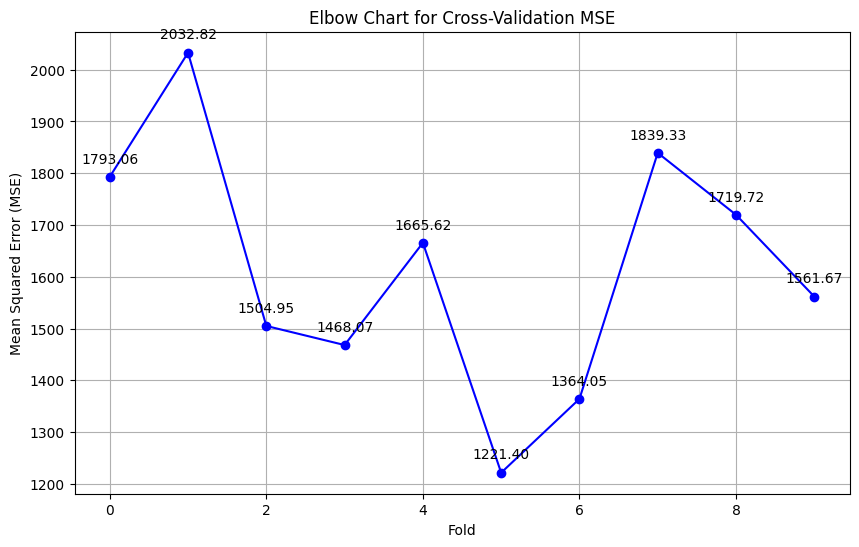

In [18]:
## Perform Linear Regression with foldsCV

X = age.to_numpy().reshape(-1,1)

mse_list = []

folds = KFold(n_splits=10)
# print(f'{folds.get_n_splits(X)} sets\n')

for i, (train_index, test_index) in enumerate(folds.split(X)):
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")

    # Define the pipeline
    pipeline = Pipeline([
        ('poly_features', PolynomialFeatures(degree=i)),  # You can change the degree if needed
        ('linear_regression', LinearRegression())
    ])

    pipeline.fit(age.to_numpy().reshape(-1,1), y)

    test_preds = pipeline.predict(X[test_index])

    # print(f'Training MSE: {mean_squared_error(y[test_index], test_preds)}')

    mse_list.append(mean_squared_error(y[test_index], test_preds))

# print(f'{folds.get_n_splits(X)} CV Average Test MSE: {round(sum(mse_list)/len(mse_list), 2)}')
print(mse_list)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(mse_list, marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Elbow Chart for Cross-Validation MSE')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error (MSE)')

# Annotate points
for i, mse in enumerate(mse_list):
    plt.annotate(f'{mse:.2f}', (i, mse), textcoords="offset points", xytext=(0,10), ha='center')

# Show the plot
plt.grid(True)
plt.show()

In [19]:
## Anova Fit

models = [MS([poly('age', degree=d)]) for d in range(1, 11)]
Xs = [model.fit_transform(wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

## It is clear that there is only benefit in adding up to 3 polynomials, as after that the p values become too large

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.763809,2.177738e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.900512,1.668545e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.814342,5.090855e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.805933,3.693976e-01
5,2993.0,4.766389e+06,1.0,3932.257665,2.470939,1.160743e-01
6,2992.0,4.763834e+06,1.0,2555.281281,1.605679,2.051988e-01
7,2991.0,4.763707e+06,1.0,126.668985,0.079596,7.778654e-01
8,2990.0,4.756703e+06,1.0,7004.317139,4.401350,3.599422e-02
9,2989.0,4.756701e+06,1.0,2.637537,0.001657,9.675292e-01


## Make a plot of the resulting polynomial fit

,coef,std err,t,P>|t|
intercept,-184.154200,60.040000,-3.067,0.002
"poly(age, degree=4, raw=True)[0]",21.245500,5.887000,3.609,0.000
"poly(age, degree=4, raw=True)[1]",-0.563900,0.206000,-2.736,0.006
"poly(age, degree=4, raw=True)[2]",0.006800,0.003000,2.221,0.026
"poly(age, degree=4, raw=True)[3]",-0.000032,0.000016,-1.952,0.051


<AxesSubplot: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='wage'>

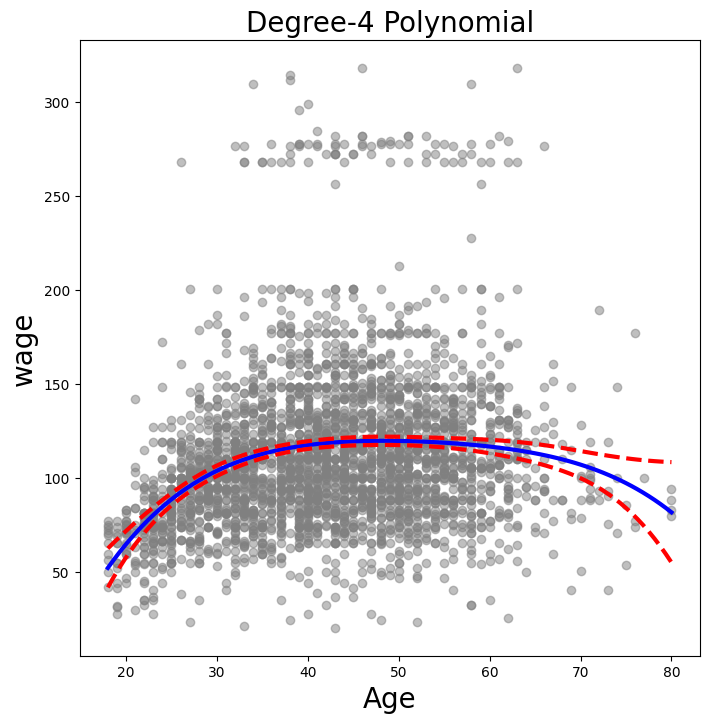

In [21]:
## Note the difference between using raw and orthogonal polynomials
## with raw=True, we return the same results as OLS with I(var**degree)

poly_age = MS([poly('age', degree=4, raw=True)]).fit(wage)

M = sm.OLS(y, poly_age.transform(wage)).fit()
display(summarize(M))

## Here, using orthogonal polynomials like in the book
poly_age = MS([poly('age', degree=4)]).fit(wage)

M = sm.OLS(y, poly_age.transform(wage)).fit()
summarize(M)

## Create a grid of values for age at which we want predictions

age_grid = np.linspace(age.min(),
age.max(),
100)
age_df = pd.DataFrame({'age': age_grid})

## We want to plot and add the fit from the fourth degree polynomial
## Defining a function that we will reuse throughout the lab

## Function that produces a fitted curve as well as 95% confidence bands
## We will use the basis arguement to plot different transforms in future uses
def plot_wage_fit(age_df, basis, title):
    X = basis.transform(wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
                y,
                facecolor='gray',
                alpha=0.5
                )
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('wage', fontsize=20);

    return ax

plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial')

b. Fit a step function to predict wage using age, and perform cross validation to choose the optimal number of cuts. Make a plot of the fit obtained

[1579.6979777362671, 1378.7003172606524, 1675.1949500123726, 1163.1024570740824, 1340.3481179583955, 1509.3314277290365, 1830.9192795568943, 1944.0861053556705, 1443.4867776276778]


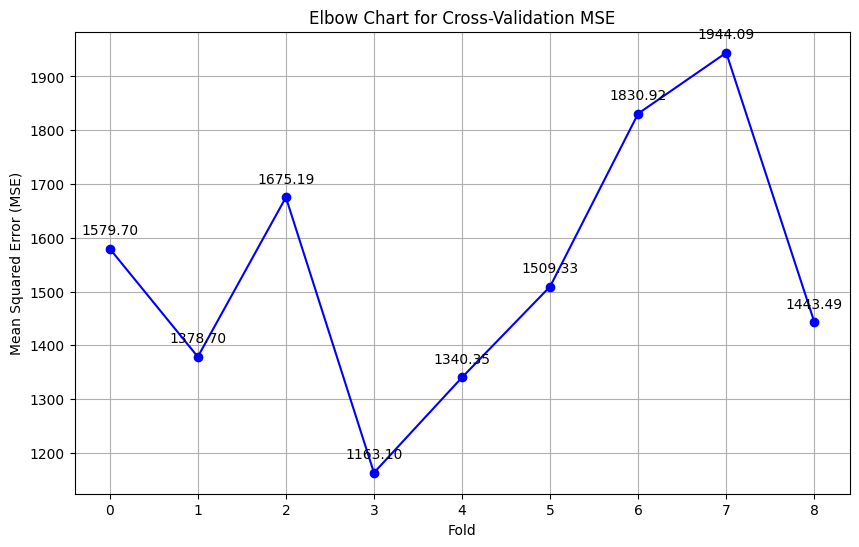

In [31]:
## Perform Linear Regression with foldsCV

X = age.to_numpy().reshape(-1,1)

mse_list = []

folds = KFold(n_splits=12)
# print(f'{folds.get_n_splits(X)} sets\n')

for i, (train_index, test_index) in enumerate(folds.split(X)):
    if i > 2:
        
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")

        # Define the pipeline
        pipeline = Pipeline([
            ('spline_features', SplineTransformer(degree=3, include_bias=True, n_knots=i)),  # You can change the degree if needed
            ('linear_regression', LinearRegression(fit_intercept=False))
        ])

        pipeline.fit(age.to_numpy().reshape(-1,1), y)

        test_preds = pipeline.predict(X[test_index])

        # print(f'Training MSE: {mean_squared_error(y[test_index], test_preds)}')

        mse_list.append(mean_squared_error(y[test_index], test_preds))

# print(f'{folds.get_n_splits(X)} CV Average Test MSE: {round(sum(mse_list)/len(mse_list), 2)}')
print(mse_list)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(mse_list, marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Elbow Chart for Cross-Validation MSE')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error (MSE)')

# Annotate points
for i, mse in enumerate(mse_list):
    plt.annotate(f'{mse:.2f}', (i, mse), textcoords="offset points", xytext=(0,10), ha='center')

# Show the plot
plt.grid(True)
plt.show()

(3000, 13)
Coefficients: [ 68.67474464  87.96131565 102.36346606 111.35570035 119.78509087
 120.9493792  117.15118959 116.60667282 120.27088591 118.75878
 107.14953025  97.20375719  96.49209314]
Coef Names: ['x0_sp_0' 'x0_sp_1' 'x0_sp_2' 'x0_sp_3' 'x0_sp_4' 'x0_sp_5' 'x0_sp_6'
 'x0_sp_7' 'x0_sp_8' 'x0_sp_9' 'x0_sp_10' 'x0_sp_11' 'x0_sp_12']
Intercept: 0.0


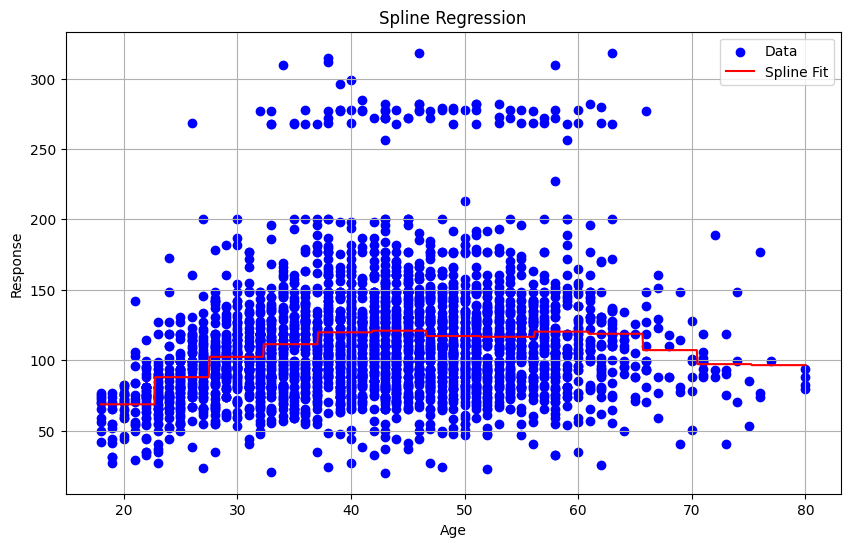

In [37]:
## Don't have to limit ourselves to cubic polynomials. Using degree 0 results in piecewise constant functions 
## This is actually the same result as in Lab 7.8.1, and the same result as above even though the coefficients are different
## It's a result of different coding. The intercept is coded by a column of 1s, so the following polynomial fits are increments for those bins in the above cell.
pipeline = Pipeline([
    ('spline_features', SplineTransformer(degree=0, n_knots=14, include_bias=True)),  # You can change the degree if needed
    ('linear_regression', LinearRegression(fit_intercept=False))
])

pipeline.fit(age.to_numpy().reshape(-1,1), y)

print(pipeline['spline_features'].transform(age.to_numpy().reshape(-1,1)).shape)

# print(pipeline['spline_features'].fit_transform(age.to_numpy().reshape(-1,1), y))

# Print the coefficients and intercept of the linear regression model
print("Coefficients:", pipeline['linear_regression'].coef_)
print("Coef Names:", pipeline['spline_features'].get_feature_names_out())
print("Intercept:", pipeline['linear_regression'].intercept_)

# Predictions
age_range = np.linspace(age.min(), age.max(), 1000).reshape(-1, 1)
predictions = pipeline.predict(age_range)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(age, y, color='blue', label='Data')
plt.plot(age_range, predictions, color='red', label='Spline Fit')
plt.title('Spline Regression')
plt.xlabel('Age')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()


